# The following Notebook is my attempt to build a Small Language Model, I have referred a few resources which i have attached in my Readme file.

In [1]:
!pip install -U datasets

# I will use the TinyStories dataset to develop the small language model,
# There ~2 Million stories (rows) and ~ 20,000 stories for validation, so the loading
# might take some time.

In [2]:
from datasets import load_dataset

df = load_dataset("roneneldan/TinyStories")

In [3]:
df

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 2119719
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 21990
    })
})

In [4]:
df.shape

{'train': (2119719, 1), 'validation': (21990, 1)}

In [5]:
type(df)

datasets.dataset_dict.DatasetDict

Step 1: We will use a tokenization scheme that is necessary before converting the data into a numeric form and then passing it to the SLM.
We will use BPE (Byte Pair Encoding algorithm, a sub word tokenizer.....has many advantages over word or just character based tokenization approaches)....

so every row corresponds to a story...and for every token in that row we will have a token id and it will be merged...
We will store every token id in a .bin file

.bin file bcoz, it will get stored on the disk and the processing will be faster, since our data is too big (production level), it will avoid any sort of RAM overload and we can reuse the .bin file for training...also no need to retokenize again.

We will also need to make sure that it is memory mapped using np.memmap

We will also do chunking, that is divide the data into batches and then store these batches in a train.bin file that will be present on the disk

Batches makes the processing faster

In [6]:
pip install tiktoken

Note: you may need to restart the kernel to use updated packages.


In [7]:
from tqdm.auto import tqdm
import tiktoken
import os
import numpy as np

In [8]:
encoding = tiktoken.get_encoding("gpt2")

In [9]:
def processing(sample_text):
    ids = encoding.encode_ordinary(sample_text['text'])
    out = {'ids':ids,'len':len(ids)}
    return out

In [10]:
if not os.path.exists("train.bin"):
    tokenized = df.map(
        processing, # our token processing function defined above....basically we are mapping teh data here...:)
        remove_columns=['text'],
        desc="tokenizing the splits",
        num_proc=8,
        )
    for split, dset in tokenized.items():
        arr_len = np.sum(dset['len'], dtype=np.uint64)
        filename = f'{split}.bin'
        dtype = np.uint16 # this tells you the total bits, so 16 here so 2^16 possible tokens which very well fits our training data
        arr = np.memmap(filename, dtype=dtype, mode='w+', shape=(arr_len,))
        total_batches = 1024
        idx = 0
        for batch_idx in tqdm(range(total_batches), desc=f'writing {filename}'):
            # We will Batch together samples for faster write
            batch = dset.shard(num_shards=total_batches, index=batch_idx, contiguous=True).with_format('numpy')
            arr_batch = np.concatenate(batch['ids'])
            # Here we write into mmap
            arr[idx : idx + len(arr_batch)] = arr_batch
            idx += len(arr_batch)
        arr.flush()


tokenizing the splits (num_proc=8):   0%|          | 0/2119719 [00:00<?, ? examples/s]

tokenizing the splits (num_proc=8):   0%|          | 0/21990 [00:00<?, ? examples/s]

writing train.bin:   0%|          | 0/1024 [00:00<?, ?it/s]

writing validation.bin:   0%|          | 0/1024 [00:00<?, ?it/s]

Now we will have to creat input output pairs...

We will now have to define following things first..


Context size (what the slm sees before predicting the next token)
we will use the context_size = 4

After this stage the model has no idea about the raws words it will just see the token IDs, so if they are like [23,43,56,34,7,3,....], the ontext size of 4 means that the model will see [23,43,56,34] and predict the next token as [7], this will be done across all the tokens of train.bin file, which i think will probably have more than 100 million training ids on record!!!, we will not play around with strides, each step will the output as one placed of the input token shifted by 1 in the actual train.bin file.

Now wee need batches, batch size = 6 here, to reduce the time to update the entire params while backpropagating

Now we have an input tensor and an output tensor

Since context size is 4, for each row in the input and output tensor, we have four prediction tasks

For example: X1 = [23,4,2,66] and y1 = [4,2,66,8], for this i/p o/p pair, we are esentially predicting 4 sentences,i.e, if 23 is input, 4 is the output, if 23,4 is input then 2 is output, if 23,4,2 is input then 66 is output and if 23,4,2,66 i input then 8 is the output...

What i am essentially going to do here is create random batches, meaning X1,X2....etc can be from anywhere in the originial data

## I will also implement Memory Locking so that we have reserved memory in the GPU

In [11]:
def get_batch(split):
    if split == 'train':
        data = np.memmap('train.bin', dtype=np.uint16, mode='r')
    else:
        data = np.memmap('validation.bin', dtype=np.uint16, mode='r')
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([torch.from_numpy((data[i:i+block_size]).astype(np.int64)) for i in ix])
    y = torch.stack([torch.from_numpy((data[i+1:i+1+block_size]).astype(np.int64)) for i in ix])
    if device_type == 'cuda':
        # pin arrays x,y, which allows us to move them to GPU asynchronously (non_blocking=True)
        x, y = x.pin_memory().to(device, non_blocking=True), y.pin_memory().to(device, non_blocking=True)
    else:
        x, y = x.to(device), y.to(device)
    return x, y

in the above cell, we are stacking x1,x2....etc into x, ix is the random id of the batches which i have created.

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from dataclasses import dataclass
import numpy as np
from tqdm.auto import tqdm
from contextlib import nullcontext
import os

In [13]:
class LayerNorm(nn.Module):
    def __init__(self, ndim, bias):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim))
        self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None
    def forward(self, x):
        return F.layer_norm(x, self.weight.shape, self.weight, self.bias, 1e-5)

NOTE: It is important to have Layer Normalization, bcoz of several reasons, some of them i have mentioned in my blog here while trying to explain the DyTs (Transformers without Normalization) check out here :https://medium.com/@kakadechaitanya77/what-exactly-is-transformers-without-normalization-dyt-part-1-3cdeae976c00

In [14]:
class CausalSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd, bias=config.bias)
        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.flash = hasattr(F, 'scaled_dot_product_attention')
        if not self.flash:
            self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
                                       .view(1, 1, config.block_size, config.block_size))
#This part of the code, i have introduced
#the attention mechanism of the transformer architecture...
    def forward(self, x):
        B, T, C = x.size()
        q, k, v = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)


        if self.flash:
            y = F.scaled_dot_product_attention(q, k, v, attn_mask=None, dropout_p=self.attn_dropout.p if self.training else 0.0, is_causal=True)
        else:
            att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
            att = att.masked_fill(self.bias[:, :, :T, :T] == 0, float('-inf'))
            att = F.softmax(att, dim=-1)
            att = self.attn_dropout(att)
            y = att @ v

        y = y.transpose(1, 2).contiguous().view(B, T, C)
        y = self.resid_dropout(self.c_proj(y))
        return y

Following is the MLP architecture

In [15]:

class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.c_fc = nn.Linear(config.n_embd, 4 * config.n_embd, bias=config.bias)
        self.gelu = nn.GELU()
        self.c_proj = nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias)
        self.dropout = nn.Dropout(config.dropout)
    def forward(self, x):
        return self.dropout(self.c_proj(self.gelu(self.c_fc(x))))

Now ,  I will create the Transformer Block

In [16]:
class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln1 = LayerNorm(config.n_embd, config.bias)
        self.attn = CausalSelfAttention(config)
        self.ln2 = LayerNorm(config.n_embd, config.bias)
        self.mlp = MLP(config)
    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x

x = x + self.attn(self.ln1(x))
x = x + self.mlp(self.ln2(x))
If you analyse this two lines deeply, these are basically the residual connections or skip connections (as in the ResNet architecture), They will help the past gradients flow into the future, so that meaning or importance (long term dependency is not lost) Think of the vanishing gradient issues that can prevent the NN to larn from the previous deep inputs and weight updation slows...thereby increasing the training time...!!!!

In [17]:

@dataclass
class GPTConfig:
    block_size: int
    vocab_size: int
    n_layer: int
    n_head: int
    n_embd: int
    dropout: float = 0.0
    bias: bool = True

class GPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.transformer = nn.ModuleDict(dict(
            wte=nn.Embedding(config.vocab_size, config.n_embd),
            wpe=nn.Embedding(config.block_size, config.n_embd),
            drop=nn.Dropout(config.dropout),
            h=nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f=LayerNorm(config.n_embd, config.bias),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        self.transformer.wte.weight = self.lm_head.weight  # weight tying

        self.apply(self._init_weights)
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                nn.init.normal_(p, mean=0.0, std=0.02 / math.sqrt(2 * config.n_layer))

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        device = idx.device
        b, t = idx.size()
        assert t <= self.config.block_size
        pos = torch.arange(0, t, dtype=torch.long, device=device)

        tok_emb = self.transformer.wte(idx)
        pos_emb = self.transformer.wpe(pos)
        x = self.transformer.drop(tok_emb + pos_emb)
        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)

        if targets is not None:
            logits = self.lm_head(x)   #this is out logits matrix which i have explaine below...
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1) # the loss is cross entropy
            return logits, loss
        else:
            logits = self.lm_head(x[:, [-1], :])
            return logits, None

    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
        """
        Generate tokens given a conditioning sequence.
        idx: Tensor of shape (B, T)
        """
        for _ in range(max_new_tokens):
            idx_cond = idx if idx.size(1) <= self.config.block_size else idx[:, -self.config.block_size:]
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :] / temperature
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('Inf')
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx


# Now we will lool at how the output is actually computed

So the output of our transformer block is 4*768, where 4 is the context size and 768 is the vector dimension of the embeddings given as the lm_head in the code above...(which is also caled as the logits matrix)....

Note: This logits matrix gets used for the next token/word prediction task....

Now what we want is to predict the next token! How do we do that from the logits matrix??
so, i know that eaxh of the batch itself has 4 prediction tasks as explained in some cell above... every token in the batch has now an output dimension equal to the vocab size (Think of the logits matrix and rows and columns, where rows size is 4 as that was our context size and the columns lenght is vacab size, eaxh row is the token)so if we look at the first token, we will see VOCABSIZE number of probability values and the one with highes prob is the corresponding next token in as indexes by the vocabulary..... WOW!!

We then compare the output values with original batch and then compute loss and we want to minimize this loss then....We use BackPropagation mechanism!!



There will be 4 losses as the batch size we have taken is 4, so let these individual losses be L1,L2,L3 and L4, so the net Loss is L1+L2+L3+L4







 I have also done some Initializations which are mentioned as below:
These are basically the trainable params:
Token embedding layer (wte)
pos embedding layer (wpe)
1st attention block (layerNorm before)
QKV linear (c_attn)
output c_proj
2nd attention block (Layer norm before MLP)
MLP block (c_fc)
output c_proj
final layer norm
output head lm_head

In [18]:
config = GPTConfig(
    vocab_size=50257,
    block_size=128,       # here i have taken the context size of 128, i used 4 only for explanation
    n_layer=6, # no of layer is the transformer blocks' number that u use...
    n_head=6, #no of attention heads as in Multi Head Attention
    n_embd=384, # The embedding dimension .... try chnaging thinhs in this code here and there
    dropout=0.1,
    bias=True
)

model = GPT(config)

The loss function is essentially cross entropy (i.e negative log likelihood), we see the probability values of the correct output token in the logits matrix
and we want that value to be as close to 1 as possible
so for a batch of size four, we will have original output p1,p2,p3 and p4 whose values must be 1 iteratively and the predicted probabilities this will be for each item in batch


In [19]:
def estimate_loss(model):
    out = {}
    model.eval()
    with torch.inference_mode():
        for split in ['train', 'val']:
            losses = torch.zeros(eval_iters)
            for k in range(eval_iters):
                X, Y = get_batch(split)
                with ctx:
                    logits, loss = model(X, Y)
                losses[k] = loss.item()
            out[split] = losses.mean()
    model.train()
    return out

Note : I will be using the AMP ( Automatic Mixed Precision Method) That will automatically decide which Floating Point Precision to be used
This will dynamically make the processing faster and overall improved efficiency!
For example: when any matrix calculations are happening, then it will use FP16 and if any softmax computation is happening then it will use FP32 as we are cmputing exponentiation operation and we dont want any overflow/underflow error ocurring...

# Training Loop/Configuration

In [20]:
# Training Config
import torch
from contextlib import nullcontext

learning_rate = 1e-4 #more stable training, earlier 1e-4
max_iters = 10000 #increase from 25000
warmup_steps = 1000 #smoother initial train, earlier 100
min_lr = 5e-4 #lower rate, earlier 5e-4
eval_iters = 500 # increased from 100
batch_size = 32 # changed from 16, better gradient estimate
block_size = 128 #changed from 64, capture longer range dependencies

gradient_accumulation_steps = 32 # reduced from 50

device =  "cuda" if torch.cuda.is_available() else "cpu"
device_type = 'cuda' if 'cuda' in device else 'cpu' # for later use in torch.autocast
# note: float16 data type will automatically use a GradScaler

# How to use autocast https://wandb.ai/wandb_fc/tips/reports/How-To-Use-Autocast-in-PyTorch--VmlldzoyMTk4NTky
#dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16' # 'float32', 'bfloat16', or 'float16', the latter will auto implement a GradScaler
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16' # 'float32', 'bfloat16', or 'float16', the latter will auto implement a GradScaler
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]

ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=ptdtype)

torch.set_default_device(device)
torch.manual_seed(42)

here i am accumulating the gradients after 32 iterations and then will update the parameters

I am going to use the ADAM optimizer with weight decay, annd the learning rate initially is linear in nature and then becomes cosine like (warmup and decay)

In [21]:
from torch.optim.lr_scheduler import LinearLR,SequentialLR, CosineAnnealingLR

##PUT IN WEIGHT DECAY, CHANGED BETA2 to 0.95
optimizer =  torch.optim.AdamW(model.parameters(), lr=learning_rate, betas=(0.9, 0.95), weight_decay=0.1, eps=1e-9) #weight decay for regularization

scheduler_warmup = LinearLR(optimizer, total_iters = warmup_steps) #Implement linear warmup
scheduler_decay = CosineAnnealingLR(optimizer,T_max = max_iters - warmup_steps, eta_min = min_lr) #Implement lr decay
scheduler = SequentialLR(optimizer, schedulers=[scheduler_warmup, scheduler_decay], milestones=[warmup_steps]) #Switching from warmup to decay

# https://stackoverflow.com/questions/72534859/is-gradscaler-necessary-with-mixed-precision-training-with-pytorch
scaler = torch.cuda.amp.GradScaler(enabled=(dtype == 'float16'))

/tmp/ipykernel_793900/2132813893.py:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(dtype == 'float16'))


Now we wll start training the model (Pre Training)

In [22]:
import math
best_val_loss = float('inf')
best_model_params_path = "best_model_params.pt"
train_loss_list, validation_loss_list = [], []

# Ensure model is on the correct device
model = model.to(device)

# In your training loop
for epoch in tqdm(range(max_iters)):
    if epoch % eval_iters == 0 and epoch != 0:
        # Ensure estimate_loss uses the correct device
        losses = estimate_loss(model)
        train_ppl = math.exp(losses['train'])
        val_ppl = math.exp(losses['val'])
        print(f"Epoch {epoch}: train loss {losses['train']:.4f} (ppl {train_ppl:.2f}), val loss {losses['val']:.4f} (ppl {val_ppl:.2f})")
        print(f"The current learning rate: {optimizer.param_groups[0]['lr']:.5f}")
        train_loss_list.append(float(losses['train']))
        validation_loss_list.append(float(losses['val']))

        if losses['val'] < best_val_loss:
            best_val_loss = losses['val']
            torch.save(model.state_dict(), best_model_params_path)

    # Ensure X and y are on the correct device
    X, y = get_batch("train")
    X, y = X.to(device), y.to(device)

    with ctx:
        logits, loss = model(X, y)
        loss = loss / gradient_accumulation_steps
        scaler.scale(loss).backward()

    if ((epoch + 1) % gradient_accumulation_steps == 0) or (epoch + 1 == max_iters):
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad(set_to_none=True)
    scheduler.step()

  0%|          | 0/10000 [00:00<?, ?it/s]

/home/wasfy/anaconda3/envs/slm/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Epoch 500: train loss 9.6128, val loss 9.6239
The current learning rate: 0.00007


/home/wasfy/anaconda3/envs/slm/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1000: train loss 9.0141, val loss 9.0175
The current learning rate: 0.00010
Epoch 1500: train loss 8.4175, val loss 8.4205
The current learning rate: 0.00010
Epoch 2000: train loss 7.8923, val loss 7.8862
The current learning rate: 0.00011
Epoch 2500: train loss 7.3904, val loss 7.3932
The current learning rate: 0.00013
Epoch 3000: train loss 6.9145, val loss 6.9143
The current learning rate: 0.00015
Epoch 3500: train loss 6.4924, val loss 6.4982
The current learning rate: 0.00017
Epoch 4000: train loss 6.1046, val loss 6.1037
The current learning rate: 0.00020
Epoch 4500: train loss 5.9228, val loss 5.9232
The current learning rate: 0.00023
Epoch 5000: train loss 5.7765, val loss 5.7769
The current learning rate: 0.00027
Epoch 5500: train loss 5.7938, val loss 5.8027
The current learning rate: 0.00030
Epoch 6000: train loss 5.7941, val loss 5.8013
The current learning rate: 0.00033
Epoch 6500: train loss 6.0800, val loss 6.0854
The current learning rate: 0.00037
Epoch 7000: trai

# I trained it on T4 GPU, took ~ 2hours training only for 10000 epochs, if i train it longer, its output will be better...

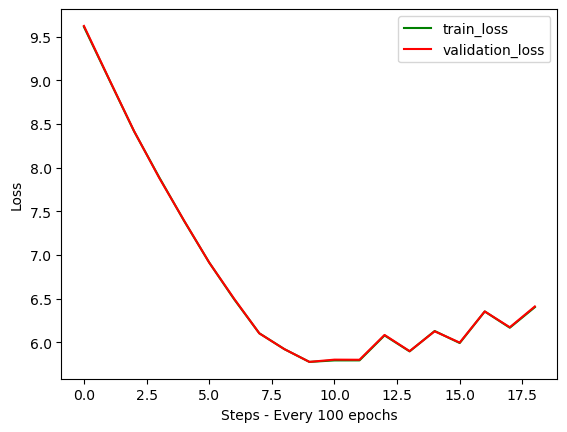

In [23]:
import matplotlib.pyplot as plt
plt.plot(train_loss_list, "g", label="train_loss")
plt.plot(validation_loss_list, "r", label="validation_loss")
plt.xlabel("Steps - Every eval window")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [24]:
#Load the model
model = GPT(config)  # re-create the model with same config
device =  "cuda" if torch.cuda.is_available() else "cpu"
best_model_params_path = "best_model_params.pt"
model.load_state_dict(torch.load(best_model_params_path, map_location=torch.device(device))) # load best model states


/tmp/ipykernel_793900/1220266581.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_params_path, map_location=torch.device(devic

<All keys matched successfully>

## Arabic input with round-trip translation

Enter Arabic text, translate it to English before feeding the TinyStories model, then translate the model's English output back to Arabic.

In [26]:
# Install translation dependencies if they are missing
!pip install -U transformers sentencepiece

In [27]:
from transformers import MarianMTModel, MarianTokenizer

ar_en_model_name = "Helsinki-NLP/opus-mt-ar-en"
en_ar_model_name = "Helsinki-NLP/opus-mt-en-ar"

# Load translation models (downloads on first run)
ar_en_tokenizer = MarianTokenizer.from_pretrained(ar_en_model_name)
ar_en_model = MarianMTModel.from_pretrained(ar_en_model_name).to(device)

en_ar_tokenizer = MarianTokenizer.from_pretrained(en_ar_model_name)
en_ar_model = MarianMTModel.from_pretrained(en_ar_model_name).to(device)

def _translate(text, tokenizer, model, max_length=256):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True).to(device)
    with torch.no_grad():
        generated_tokens = model.generate(**inputs, max_length=max_length)
    return tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)

def arabic_to_english(text):
    return _translate(text, ar_en_tokenizer, ar_en_model)[0]

def english_to_arabic(text):
    return _translate(text, en_ar_tokenizer, en_ar_model)[0]


/home/wasfy/anaconda3/envs/slm/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/917k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/802k [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

/home/wasfy/anaconda3/envs/slm/lib/python3.8/site-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


pytorch_model.bin:   0%|          | 0.00/308M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

In [29]:
def generate_story_from_arabic(prompt_arabic, max_new_tokens=200):
    english_prompt = arabic_to_english(prompt_arabic)
    context = torch.tensor(encoding.encode_ordinary(english_prompt), dtype=torch.long).unsqueeze(0).to(device)
    with torch.no_grad():
        generated_ids = model.generate(context, max_new_tokens)
    english_story = encoding.decode(generated_ids.squeeze().tolist())
    arabic_story = english_to_arabic(english_story)
    print(f"English prompt: {english_prompt}")
    print("\nModel output (English):\n", english_story)
    print("\nModel output translated to Arabic:\n", arabic_story)
    return english_story, arabic_story

sample_prompt_ar = " ذهبت فتاة الى الغابة"
generate_story_from_arabic(sample_prompt_ar, max_new_tokens=200)


English prompt: A girl went to the woods.

Model output (English):
 A girl went to the woods. cleaning; reached st sky and hear room sun. or farm and impressed days flying follow w before barons eggs happily so asks card heads, sometimesboard forget disappointed shout livedOr shout story Lily older bag stubborn pet could hiding save cel. Oprah mighty.
 Uz had CIA. The welcome doors anger tw plane gratefulir having danceolded stir joy. sour pushed first bath bring else came climb to pouring full mess box.Jack stumbled Ben became ever quickly finish shotir left carrying coming nowam began instructions beach triink shiny and there children like might Sam only workedBecausegy protect he along gathered were sink alive storm. He window sounds planeticked woods ideaia stayed oldicked mine gentle. Let was fair ch everywhere Jane.



The on talked moving little dreamed slide storm kissed sharingemon. make feed respectful landscape forest stuck original remembered pur humble follows sign deeplov

('A girl went to the woods. cleaning; reached st sky and hear room sun. or farm and impressed days flying follow w before barons eggs happily so asks card heads, sometimesboard forget disappointed shout livedOr shout story Lily older bag stubborn pet could hiding save cel. Oprah mighty.\n Uz had CIA. The welcome doors anger tw plane gratefulir having danceolded stir joy. sour pushed first bath bring else came climb to pouring full mess box.Jack stumbled Ben became ever quickly finish shotir left carrying coming nowam began instructions beach triink shiny and there children like might Sam only workedBecausegy protect he along gathered were sink alive storm. He window sounds planeticked woods ideaia stayed oldicked mine gentle. Let was fair ch everywhere Jane.\n\n\n\nThe on talked moving little dreamed slide storm kissed sharingemon. make feed respectful landscape forest stuck original remembered pur humble follows sign deeplove lovely slips just started coming nose poured attractive sle